<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
categories = ['PNEUMONIA', 'NORMAL']
img_size = 224 

def get_images(dir): 
    images_array = []
    for category in categories: 
        path = os.path.join(dir, category)
        label = categories.index(category)
        for image in tqdm(os.listdir(path)): 
            try:
                img_arr = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # set image size 
                images_array.append([resized_arr, label])
            except Exception as e:
                print(e)
    return np.array(images_array)

train = get_images('/content/drive/MyDrive/Pneumonia/train')
test = get_images('/content/drive/MyDrive/Pneumonia/test')
val = get_images('/content/drive/MyDrive/Pneumonia/val')

100%|██████████| 1359/1359 [00:39<00:00, 34.63it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()
100%|██████████| 8/8 [00:00<00:00, 62.56it/s]


In [3]:
# #pneumonia: label (0) & normal : label (1)
# total_p = len(train[:, [1]]) - sum(train[:, [1]])
# total_n = sum(train[:, [1]])
# fig, ax =  plt.subplots(figsize = (5, 5))
# ax.bar(['pneumonia','normal'], [total_p[0], total_n[0]], color = ('#990000', '#004c70'))
# for s in ["top","right"]:
#     ax.spines[s].set_visible(False)

# #annotate y-value
# for bar in ax.patches: 
#   ax.annotate(f"{bar.get_height():.0f}", 
#                    xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
#                    ha = 'center', va = 'center', 
#                    xytext = (0, 7), 
#                    textcoords = 'offset points')

# # y-axis tick
# grid_y_ticks = np.arange(0, 4400, 1000)
# ax.set_yticks(grid_y_ticks)
# ax.grid(axis='y', linestyle='-', alpha=0.3)

In [4]:
# x_train = train[:, [0]][0].tolist()
# y_train = train[:, [1]].flatten().tolist()
                
# x_val = val[:, [0]][0].tolist()
# y_val = val[:, [1]].flatten().tolist()
                
# x_test = test[:, [0]][0].tolist()
# y_test = test[:, [1]].flatten().tolist() 

# # Normalize the data
# x_train = np.array(x_train) / 255
# x_val = np.array(x_val) / 255
# x_test = np.array(x_test) / 255

# # resize data for deep learning 
# x_train = x_train.reshape(-1, img_size, img_size, 1)
# y_train = np.array(y_train)

# x_val = x_val.reshape(-1, img_size, img_size, 1)
# y_val = np.array(y_val)

# x_test = x_test.reshape(-1, img_size, img_size, 1)
# y_test = np.array(y_test)

# y_train

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [6]:
datagen = ImageDataGenerator(
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.1,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True)  # randomly flip images)  

null_datagen = ImageDataGenerator()

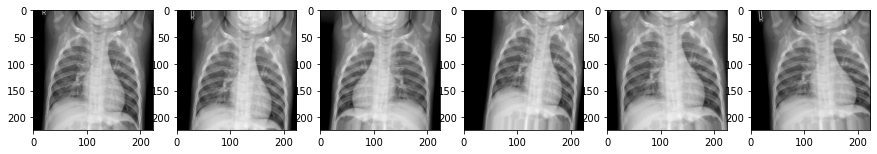

In [7]:
#augmented images of a sample image 
fig, axes = plt.subplots(1,6,figsize=(15,15))
axes[0].imshow(x_train[0][:,:,0], cmap='gray')
for i in range(5): 
  sample, label = datagen.flow(x_train[:1], y_train[:1]).__getitem__(0)
  for img in sample: 
    axes[i+1].imshow(img[:,:,0], cmap='gray')

In [8]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

balanced_gen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32) 
# steps_per_epoch = balanced_gen.steps_per_epoch #generated_image, label = train.__getitem__(18)
# y_gen = [balanced_gen.__getitem__(0)[1] for i in range(steps_per_epoch)]
# print(np.unique(y_gen, return_counts=True)) #number of each label changes every training *

In [13]:
#model 
def model(): 
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    return model
# model.summary()
model = model()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [12]:
#augmented but still imbalance 
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) , epochs = 20 , validation_data =  null_datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
166/166 [==============================] - 30s 148ms/step - loss: 0.6206 - accuracy: 0.8462 - val_loss: 73.0682 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - 28s 169ms/step - loss: 0.2643 - accuracy: 0.9127 - val_loss: 14.3175 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9305
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
166/166 [==============================] - 23s 139ms/step - loss: 0.1977 - accuracy: 0.9305 - val_loss: 68.9626 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
166/166 [==============================] - 22s 132ms/step - loss: 0.1259 - accuracy: 0.9567 - val_loss: 6.6048 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/20
166/166 [==============================] - 27s 159ms/step - loss: 0.1191 - accuracy: 0.9592 - val_loss: 0.6379 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/20
166/166 [==================

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
model = model()
history = model.fit(balanced_gen, epochs = 20 , validation_data = null_datagen.flow(x_val, y_val), callbacks = [learning_rate_reduction])
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
#@title 
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()